In [88]:
ENV = 'colab'
# ENV = 'local'

In [89]:
if 'colab' in ENV:
  !pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.2)


In [90]:
import warnings
warnings.filterwarnings('ignore')

from dataclasses import dataclass

import numpy   as np
import pandas  as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
from   six               import StringIO  
from   IPython.display   import Image
import pydotplus

from sklearn.experimental    import enable_iterative_imputer
from sklearn.model_selection import train_test_split, StratifiedKFold, \
                                    RandomizedSearchCV
from sklearn.impute          import IterativeImputer
from sklearn.preprocessing   import LabelEncoder
from sklearn.tree            import DecisionTreeClassifier, export_graphviz
from sklearn.metrics         import accuracy_score, confusion_matrix, \
                                    plot_confusion_matrix, \
                                    f1_score, precision_score, \
                                    recall_score, make_scorer

from imblearn.over_sampling  import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline       import Pipeline

# Trabajo Practico 1

Configuracion común:

In [91]:
sns.set(style="darkgrid")
tiny_size = lambda: sns.set(rc={'figure.figsize':(5,5)})
normal_size = lambda: sns.set(rc={'figure.figsize':(10, 6)})
big_size = lambda: sns.set(rc={'figure.figsize':(20,5)})

## Pasos

#### A) A partir de los datos entregados, describir los atributos realizando una breve explicación de qué representan y del tipo de variable (categórica, numérica u ordinal). En caso de que haya variables no numéricas, reportar los posibles valores que toman y cuán frecuentemente lo hacen.

In [93]:
if 'colab' in ENV:
    from google.colab import files
    uploaded = files.upload()
    dataset = pd.read_csv('./healthcare-dataset-stroke-data.csv')
else:
    dataset = pd.read_csv('../dataset/healthcare-dataset-stroke-data.csv')

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data (9).csv


In [166]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#### Genero

Es una variable categorica con los siguentes posibles valores:

In [167]:
dataset.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [168]:
dataset['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

#### Edad

Es una variable ordinal categorica:

<AxesSubplot:xlabel='age', ylabel='Count'>

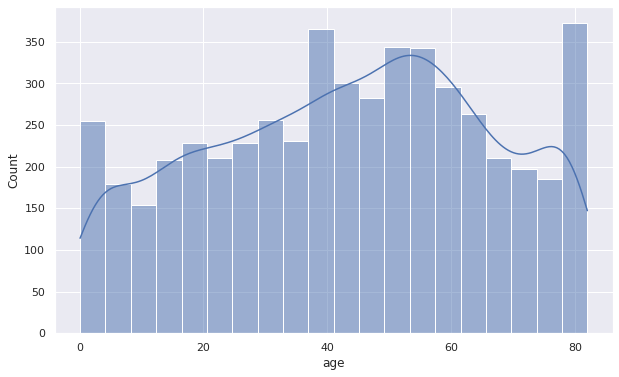

In [169]:
normal_size()
sns.histplot(data=dataset, x='age', kde=True)

In [170]:
dataset['age'].value_counts()

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.08       2
0.40       2
Name: age, Length: 104, dtype: int64

#### Hypertension

Indica si el paciente tiene hipertension o no. Es una variable categorica con los siguentes posibles valores:

In [171]:
dataset['hypertension'].unique()

array([0, 1])

<AxesSubplot:xlabel='Count', ylabel='hypertension'>

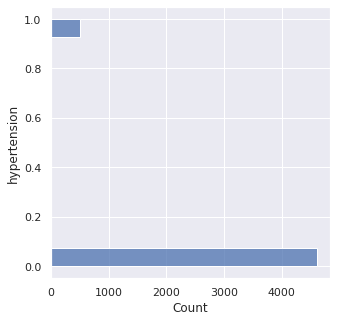

In [172]:
tiny_size()
sns.histplot(data=dataset, y='hypertension')

In [173]:
dataset['hypertension'].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

#### Heart Disease

Explica si el individio tiene una enfermedad cardiaca o no. Es una variable categorica con los siguentes posibles valores:

In [174]:
dataset['heart_disease'].unique()

array([1, 0])

<AxesSubplot:xlabel='Count', ylabel='heart_disease'>

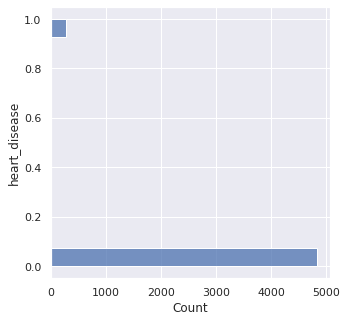

In [175]:
tiny_size()
sns.histplot(data=dataset, y='heart_disease')

In [176]:
dataset['heart_disease'].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

#### Ever Married

El individuo estuvo o esta casado?. Es una variable categorica con los siguentes posibles valores:

In [177]:
dataset['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

<AxesSubplot:xlabel='Count', ylabel='ever_married'>

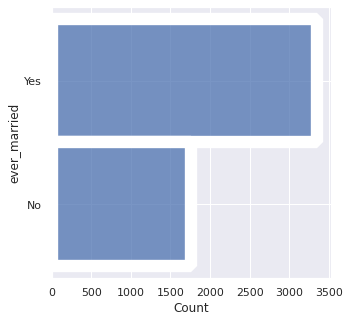

In [178]:
tiny_size()
sns.histplot(data=dataset, y='ever_married')

In [179]:
dataset['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

#### Work Type

Tipo de trabajo. Es una variable categorica con los siguentes posibles valores:

In [180]:
dataset['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

<AxesSubplot:xlabel='Count', ylabel='work_type'>

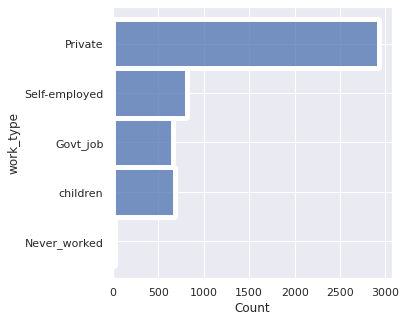

In [181]:
tiny_size()
sns.histplot(data=dataset, y='work_type')

In [182]:
dataset['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

#### Residence type

Tipo de zona donde reside el invididuo. Es una variable categorica con los siguentes posibles valores:

In [183]:
dataset['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

<AxesSubplot:xlabel='Count', ylabel='Residence_type'>

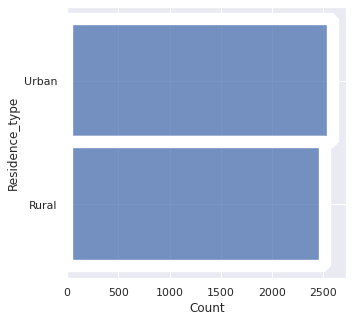

In [184]:
tiny_size()
sns.histplot(data=dataset, y='Residence_type')

In [185]:
dataset['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

#### AVG Glucose Level

Nivel de grucosa medio el individuo. Es una variable numerica.

In [186]:
dataset['avg_glucose_level'].unique()

array([228.69, 202.21, 105.92, ...,  82.99, 166.29,  85.28])

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

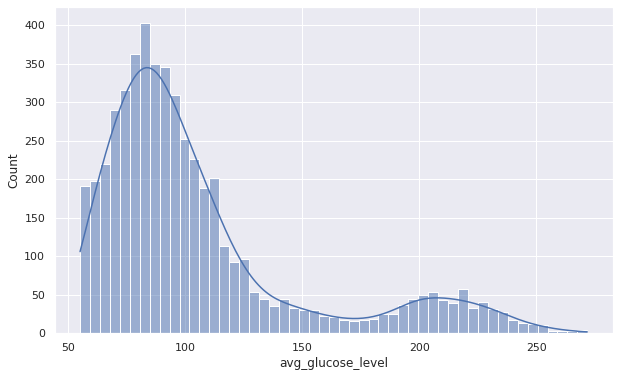

In [187]:
normal_size()
sns.histplot(data=dataset, x='avg_glucose_level', kde=True)

#### BMI

Es una variable numerica. Body Mass Index (Peso / Altura^2)

<AxesSubplot:xlabel='bmi', ylabel='Count'>

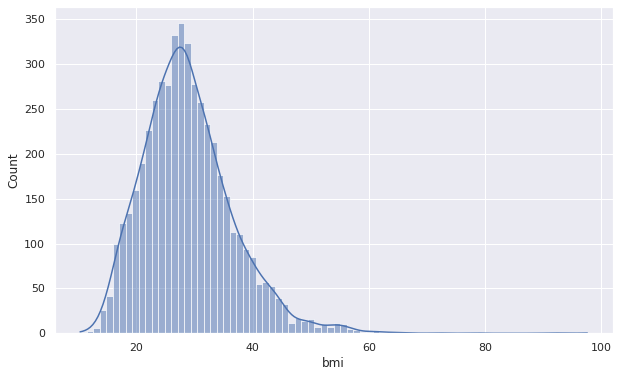

In [188]:
normal_size()
sns.histplot(data=dataset, x='bmi', kde= True)

#### Smoking Status

Se refiere al nivel de fumador al que perteneces el individuo. Es una variable categorica con los siguentes posibles valores:

In [189]:
dataset['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

<AxesSubplot:xlabel='Count', ylabel='smoking_status'>

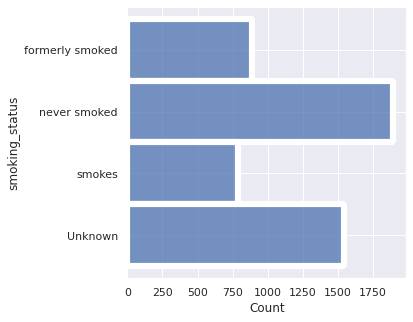

In [190]:
tiny_size()
sns.histplot(data=dataset, y='smoking_status')

In [191]:
dataset['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

#### Stroke

Informa si el individuo sufrio un derrame cerebral o no. Es una variable categorica con los siguentes posibles valores:

In [192]:
dataset['stroke'].unique()

array([1, 0])

<AxesSubplot:xlabel='Count', ylabel='stroke'>

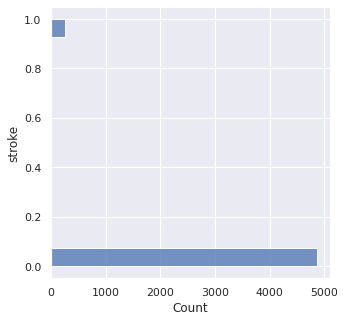

In [193]:
tiny_size()
sns.histplot(data=dataset, y='stroke')

In [194]:
dataset['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

#### b) Reportar si hay valores faltantes. ¿Cuántos son y en qué atributos se encuentran? En caso de haberlos, ¿es necesario y posible asignarles un valor?

Antes de completar valores faltante vamos a separar el dataset en los conjuntos en dos conjuntos, development, validation y test:

In [195]:
def missing_values_summary(df):
    result = round(df.isna().sum() * 100 / len(dataset), 2)
    result = result[result > 0]
    result = result.apply(lambda value: f'{value}%')
    return result 

def set_summary(features, target, title=None):
    if title:
        print(f'\n{title}:')
    print('- Features shape:',  features.shape)
    print('- Target shape:',     target.shape)
    print('- Target classes:')
    classes = target.value_counts(normalize=True)
    values = classes * 100

    print("\t- Clase {}: {:.2f} %".format(str(classes.index[0][0]), values.values[0]))
    print("\t- Clase {}: {:.2f} %".format(str(classes.index[1][0]), values.values[1]))

    missing = missing_values_summary(features)

    if missing.empty:
        print('- Features Missing values: No missing values!')
    else:
        print('- Features Missing values: ')
        print(missing)


In [196]:
def num_column_names(df):
    return df.select_dtypes(include=np.number).columns

def cat_column_names(df):
    return set(df.columns) - set(num_column_names(df))

def cat_column_indexes(df):
    return [df.columns.get_loc(col_name) for col_name in cat_column_names(df)]

def unique_column_values(df, column_name): 
    return df[column_name].value_counts().index.values

In [197]:
@dataclass
class SetsGroup:
    dev_features: pd.DataFrame
    test_features: pd.DataFrame
    dev_target: pd.DataFrame
    test_target: pd.DataFrame

    def summary(self):
        set_summary(self.dev_features, self.dev_target, title='Development Set')
        set_summary(self.test_features, self.test_target, title='Test Set')

    def features(self):
        return pd.concat([self.dev_features, self.test_features])
    
    def cat_feature_names(self):
        return cat_column_names(self.dev_features)

    def cat_feature_indexes(self):
        return cat_column_indexes(self.dev_features)

    def num_feature_names(self):
        return num_column_names(self.dev_features)

    def feature_unique_values(self, column_name):
        return unique_column_values(self.features(), column_name)

    def dev_set(self):      
        return pd.concat([sets_group.dev_features,sets_group.dev_target], axis=1)

class DevTestSpliter:
    @staticmethod
    def split(
        dataset, 
        target_col = 'stroke', 
        test_size = 0.2,
        random_state = 1
    ):
        features = dataset.loc[:, dataset.columns != target_col]
        target   = dataset[[target_col]]

        dev_features, test_features, dev_target, test_target = train_test_split(
            features, 
            target, 
            test_size    = test_size,
            random_state = random_state,
            stratify     = target.values
        )
        return SetsGroup(dev_features, test_features, dev_target, test_target)

In [198]:
sets_group = DevTestSpliter.split(dataset, test_size = 0.2)
sets_group.summary()


Development Set:
- Features shape: (4088, 11)
- Target shape: (4088, 1)
- Target classes:
	- Clase 0: 95.13 %
	- Clase 1: 4.87 %
- Features Missing values: 
bmi    3.39%
dtype: object

Test Set:
- Features shape: (1022, 11)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0: 95.11 %
	- Clase 1: 4.89 %
- Features Missing values: 
bmi    0.55%
dtype: object


La unica variable que tiene valores incompletos es BMI y es un 3.93%.

Ahora completamos valores faltantes y comparamos la distribucion de la columna BMI antes y despues de la imputacion:

In [199]:
def impute_missing_values(df, excluded = ['id'], random_state=0):
    num_features = df.select_dtypes(include=np.number)
    num_features = num_features[set(num_features.columns) - set(excluded)]

    # Algoritmo basado en el algoritmo MICE de R
    imputer = IterativeImputer(random_state=random_state) 
    imputer.fit(num_features)

    imp_num_features = imputer.transform(num_features)

    result_df = pd.DataFrame(
        data    = imp_num_features, 
        columns = num_features.columns
    )
    for col in cat_column_names(df):
        result_df[col] = df[col].values

    return result_df

class MissingValuesImpoter:
    def __init__(self, excluded = ['id'], random_state=0):
        self.excluded     = excluded
        self.random_state = random_state
    
    def impute(self, sets_group):
        imp_dev_features  = impute_missing_values(
            sets_group.dev_features,
            random_state = self.random_state
        )
        imp_test_features = impute_missing_values(
            sets_group.test_features,
            random_state = self.random_state
        )
        return SetsGroup(
            imp_dev_features, 
            imp_test_features, 
            sets_group.dev_target, 
            sets_group.test_target
        )


def compare_distributions(df1, df2, column):
    sns.kdeplot(df1[column], shade=True, color="r")
    sns.kdeplot(df2[column], shade=True, color="b")

Chequeamos que se hayan completado als columnas y comparamos las distribuciones para development y test:

In [200]:
imputer = MissingValuesImpoter()
imp_sets_group = imputer.impute(sets_group)
imp_sets_group.summary()


Development Set:
- Features shape: (4088, 10)
- Target shape: (4088, 1)
- Target classes:
	- Clase 0: 95.13 %
	- Clase 1: 4.87 %
- Features Missing values: No missing values!

Test Set:
- Features shape: (1022, 10)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0: 95.11 %
	- Clase 1: 4.89 %
- Features Missing values: No missing values!


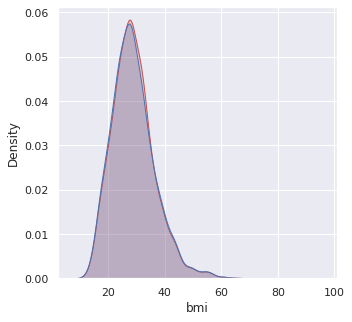

In [201]:
compare_distributions(imp_sets_group.dev_features, sets_group.dev_features, 'bmi')

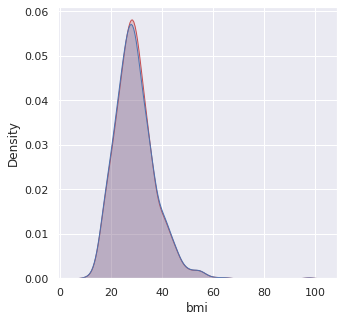

In [202]:
compare_distributions(imp_sets_group.test_features, sets_group.test_features, 'bmi')

Ahora la columna BMI esta completa.

#### c) ¿Qué variables se correlacionan más con el evento de lesión (Stroke)? Para las cuatro más correlacionadas, realizar un gráfico en el que se pueda observar la correlación entre la variable y el stroke.

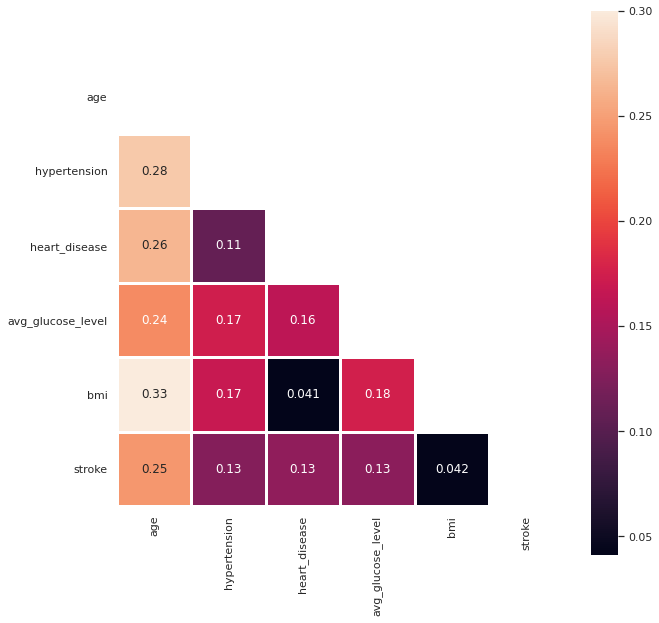

In [203]:
def heatmap(corr, resumed=True, figsize=(10, 10), vmax=.3, square=True, annot=True, linewidths=3):
    if resumed:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(corr, mask=mask, vmax=vmax, square=square, annot=annot, linewidths=linewidths)

        
tmp_dataset = dataset.drop('id', axis=1)
heatmap(tmp_dataset.corr())

Al parecer stroke tiene baja correlacion con las demas variables pero existe un nivel. El orden de mas correlacionada a menos es:

* Age (0.25)
* Hypertension, Heart Disease y AVG Glucose Level (0.13)
* BMI (0.044)

**Edad vs. dañoi cerebral**

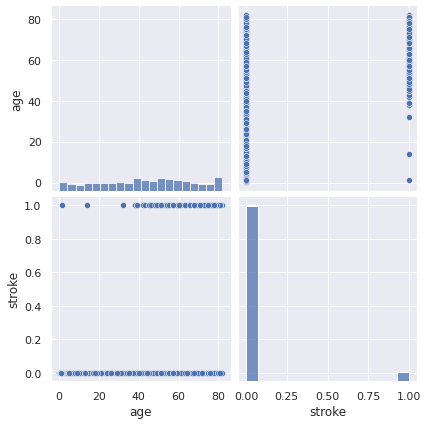

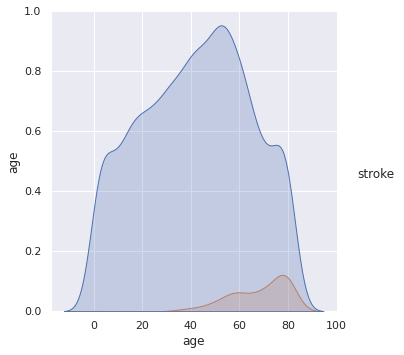

In [204]:
sns.pairplot(tmp_dataset[['age', 'stroke']], height=3)
sns.pairplot(tmp_dataset[['age','stroke']], hue="stroke", height=5)

Conclusiones:

* Ambas densidades estan solapadas.
* Para age <= 23: La probabilidad de tener un daño cereblar es practicamente nula.
* Para age > 23: La probabilidad de tener un daño cereblar es conciderable pero sigue siendo baja con relaciona a la probabilidad de no tener daño cerebral.

**Hipertensión vs daño cerebral**

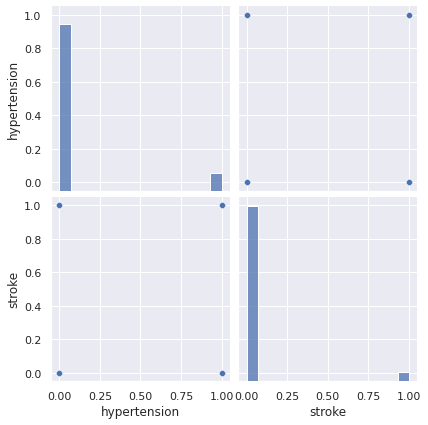

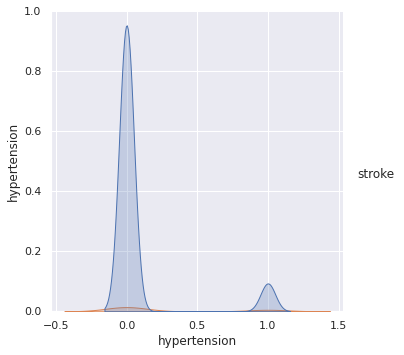

In [205]:
sns.pairplot(tmp_dataset[['hypertension', 'stroke']], height=3)
sns.pairplot(tmp_dataset[['hypertension','stroke']], hue="stroke", height=5)

Conclusiones:
    
* Ambas densidades estan solapadas.
* -0.2 <= hypertension <= 0.2
    * P(Daño cerebral/ Nivel de hipertension) <<<< P(Daño cerebral/ Nivel de hipertension)
* 0.8 <= hypertension <= 1.2
    * P(Daño cerebral/ Nivel de hipertension) <<<< P(No Daño cerebral/ Nivel de hipertension)
* En otros valores hay una probabilidad muy baja de daño cereblar.

**Enfermedad del corazón vs daño cerebral**

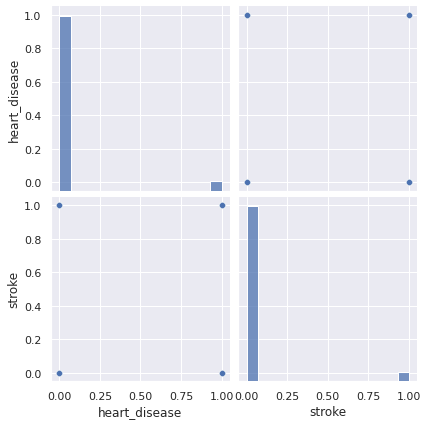

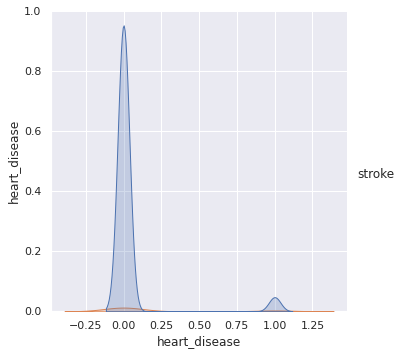

In [206]:
sns.pairplot(tmp_dataset[['heart_disease', 'stroke']], height=3)
sns.pairplot(tmp_dataset[['heart_disease','stroke']], hue="stroke", height=5)

Conclusiones:
    
* Ambas densidades estan solapadas.
* -0.2 <= heart_disease <= 0.2
    * P(Daño cerebral/ Enfermedad del corazón) <<<< P(No Daño cerebral/ Enfermedad del corazón)
* 0.8.5 <= hypertension <= 1.1
    * P(Daño cerebral/ Enfermedad del corazón) <<<< P(No Daño cerebral/ Enfermedad del corazón)
* En otros valores hay una probabilidad muy baja de daño cereblar.

**Promedio del nivel de glucosa vs daño cerebral**

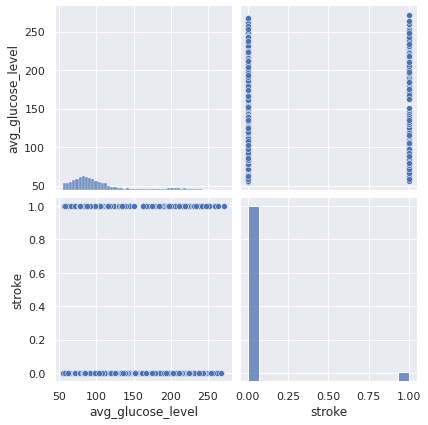

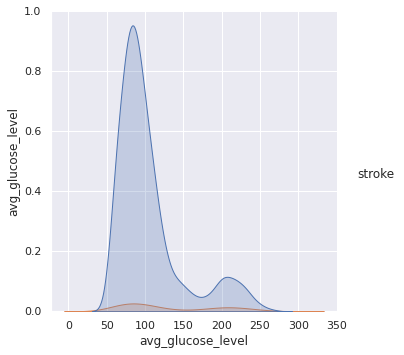

In [207]:
sns.pairplot(tmp_dataset[['avg_glucose_level', 'stroke']], height=3)
sns.pairplot(tmp_dataset[['avg_glucose_level','stroke']], hue="stroke", height=5)

Conclusiones:
    
* Ambas densidades estan solapadas.
* - 40 <= avg_glucose_level <= 170
    * P(Daño cerebral/ nivel de glucosa) <<<< P(No Daño cerebral/ nivel de glucosa)
* 0.8.5 <= hypertension <= 1.1
    * P(Daño cerebral/ nivel de glucosa) <<<< P(No Daño cerebral/ nivel de glucosa)
* En otros valores hay una probabilidad muy baja de daño cereblar.

#### d) Se necesita saber cuáles son los indicadores que determinan más susceptibilidad a sufrir una lesión. ¿Qué atributos utilizará como variables predictoras? ¿Por qué?

Completar

#### e) ¿Se encuentra balanceado el conjunto de datos que utilizará para desarrollar el algoritmo diseñado para contestar el punto d)? En base a lo respondido, ¿qué métricas de performance reportaría y por qué? En caso de estar desbalanceado, ¿qué estrategia de balanceo utilizaría?

In [208]:
imp_sets_group.summary()


Development Set:
- Features shape: (4088, 10)
- Target shape: (4088, 1)
- Target classes:
	- Clase 0: 95.13 %
	- Clase 1: 4.87 %
- Features Missing values: No missing values!

Test Set:
- Features shape: (1022, 10)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0: 95.11 %
	- Clase 1: 4.89 %
- Features Missing values: No missing values!


**Claramente esta desbalanceado** dado que es normal tener menos casos de daño cerebral.

In [209]:
class OverUnderSampler:    
    def __init__(
        self,
        categorical_features, 
        random_state=None, 
        oversampling_strategy='auto', 
        undersampling_strategy='auto'
    ):
        oversampler = SMOTENC(
            categorical_features = categorical_features, 
            random_state = random_state,
            sampling_strategy = undersampling_strategy
        )
        undersampler = RandomUnderSampler(sampling_strategy = undersampling_strategy)
        self.pipeline = Pipeline(steps=[('oversampler', oversampler), ('undersampler', undersampler)])

    def perform(self, features, target):
        bal_features, bal_target = self.pipeline.fit_resample(features.values, target.values)
        
        # Matrix to DataFrame
        bal_features = pd.DataFrame(data = bal_features, columns = features.columns)
        bal_target   = pd.DataFrame(data = bal_target,   columns = target.columns)

        return bal_features, bal_target

In [210]:
class SetsGroupOverUnderSampler:
    @staticmethod
    def createFromHps(categorical_features, hps):
        return SetsGroupOverUnderSampler(
            categorical_features   = categorical_features,
            random_state           = hps.random_state, 
            oversampling_strategy  = hps.oversampling_strategy,
            undersampling_strategy = hps.undersampling_strategy 
        )

    def __init__(
        self,
        categorical_features,
        random_state = None, 
        oversampling_strategy = 0.1,
        undersampling_strategy = 1
    ):
        self.sampler = OverUnderSampler(
            categorical_features   = categorical_features,
            random_state           = random_state, 
            oversampling_strategy  = oversampling_strategy,
            undersampling_strategy = undersampling_strategy
        )

    def perform(self, sets_group):
        bal_dev_features, bal_dev_target = self.sampler.perform(
            sets_group.dev_features, 
            sets_group.dev_target
        )

        return SetsGroup(
            bal_dev_features, 
            sets_group.test_features, 
            bal_dev_target, 
            sets_group.test_target
        )

In [211]:
sampler = SetsGroupOverUnderSampler(
    categorical_features   = imp_sets_group.cat_feature_indexes(),
    oversampling_strategy  = 0.1,
    undersampling_strategy = 1
)
oversampled_sets_group = sampler.perform(imp_sets_group)
oversampled_sets_group.summary()


Development Set:
- Features shape: (7778, 10)
- Target shape: (7778, 1)
- Target classes:
	- Clase 1: 50.00 %
	- Clase 0: 50.00 %
- Features Missing values: No missing values!

Test Set:
- Features shape: (1022, 10)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0: 95.11 %
	- Clase 1: 4.89 %
- Features Missing values: No missing values!


#### f) Suponiendo que es más importante detectar los casos en donde el evento ocurre. ¿Qué medida de performance utilizaría? Si utiliza Fβ-Score, ¿qué valor de β eligiría?

**Completar!**

#### g) Implementar el algoritmo introducido en el punto d) utilizando árboles de decisión. En primer lugar, se deberá separar un 20% de los datos para usarlos como conjunto de evaluación (test set). El conjunto restante (80%) es el de desarrollo y es con el que se deberá continuar haciendo el trabajo. Realizar los siguientes puntos

In [212]:
class CategoricalFeaturesEncoder:
    def perform(self, sets_group):
        enc_dev_features  = sets_group.dev_features.copy()
        enc_test_features = sets_group.test_features.copy()
 
        for col_name in sets_group.cat_feature_names():            
            encoder = LabelEncoder()
            encoder.fit(sets_group.feature_unique_values(col_name))

            enc_test_features[col_name] = encoder.transform(sets_group.test_features[col_name].values)
            enc_dev_features[col_name]  = encoder.transform(sets_group.dev_features[col_name].values)


        return SetsGroup(
            enc_dev_features, 
            enc_test_features, 
            sets_group.dev_target, 
            sets_group.test_target
        )

In [213]:
encoder = CategoricalFeaturesEncoder()
encoded_sets_group = encoder.perform(oversampled_sets_group)
encoded_sets_group.summary()


Development Set:
- Features shape: (7778, 10)
- Target shape: (7778, 1)
- Target classes:
	- Clase 1: 50.00 %
	- Clase 0: 50.00 %
- Features Missing values: No missing values!

Test Set:
- Features shape: (1022, 10)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0: 95.11 %
	- Clase 1: 4.89 %
- Features Missing values: No missing values!


In [215]:
encoder = CategoricalFeaturesEncoder()
encoded_sets_group = encoder.perform(encoded_sets_group)
encoded_sets_group.summary()


Development Set:
- Features shape: (7778, 10)
- Target shape: (7778, 1)
- Target classes:
	- Clase 1: 50.00 %
	- Clase 0: 50.00 %
- Features Missing values: No missing values!

Test Set:
- Features shape: (1022, 10)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0: 95.11 %
	- Clase 1: 4.89 %
- Features Missing values: No missing values!


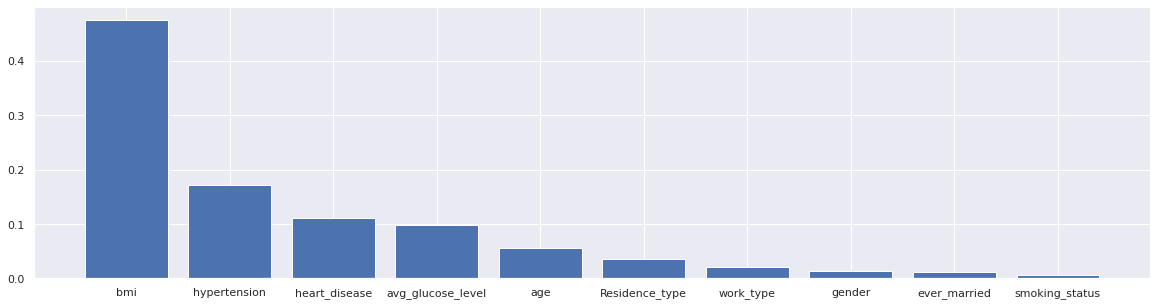

In [216]:
def features_importance(features, target):
    model = DecisionTreeClassifier()
    model.fit(features, target)
    importance = model.feature_importances_

    # Orden desc...
    return np.sort(importance)[::-1]

def plot_features_importance(sets_group):
    importance = features_importance(
        sets_group.dev_features.values, 
        sets_group.dev_target.values
    )

    column_names = sets_group.dev_features.columns
    plt.bar([column_names[x] for x in range(len(importance))], importance)
    plt.show()

big_size()
plot_features_importance(encoded_sets_group)

Quitamos los features menos importantes para la clasificacion por stroke:

In [217]:
def remove_columns(df, columns): df.drop(columns, axis = 1, inplace=True)

In [218]:
less_importante_features = [
    'Residence_type',
    'smoking_status',
    'gender',
    'ever_married',
    'work_type'
]

remove_columns(encoded_sets_group.dev_features, less_importante_features)
remove_columns(encoded_sets_group.test_features, less_importante_features)

In [220]:
def to_tree_img(tree):
    dot_data = StringIO()
    export_graphviz(
        tree, 
        out_file            = dot_data,  
        filled              = True,
        rounded            = True,
        special_characters = True
    )
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png('tree.png')
    return mpimg.imread('tree.png')

def plot_tree(tree):
    sns.set(rc={'figure.figsize':(15, 8)})
    plt.title('Arbol de decisión')
    plt.grid(False)
    plt.imshow(to_tree_img(tree))
    plt.axis('off')
    plt.show()
    
def cm_plot(ax, cm, title='Matriz de confusión'):     
    sns.heatmap(
        cm, 
        ax=ax,
        annot=True, 
        fmt='g', 
        cmap='Blues', 
        cbar=False
    )
    ax.set_ylabel('Realidad')
    ax.set_xlabel('Predicciones')
    ax.set_title(title)

In [221]:
@dataclass
class HiperParams:
    # Hiper parametros del modelo:
    criterion: any = 'entropy' 
    max_depth: int = 5
    min_samples_leaf: int = 1
    ccp_alpha: float = 0.0
    class_weight: any = 'balanced'
    # Semilla usada en todos lo algoritmos.
    random_state: int = 42 
    # Hiper parametros para over/up sampling:
    # Porcentaje de ejemplos duplicados en la calse minoritaria.
    oversampling_strategy: float = 0.1
    # Porcentaje de ejemplos removidos ne la clase mayoritaria.
    undersampling_strategy: float = 1

class ModelFactory:
    @staticmethod
    def create(hps):
        tree = DecisionTreeClassifier(
            criterion        = hps.criterion,
            max_depth        = hps.max_depth,
            min_samples_leaf = hps.min_samples_leaf,
            ccp_alpha        = hps.ccp_alpha,
            class_weight     = hps.class_weight,
            random_state     = hps.random_state
        )
        return Model(tree, hps)

    def create_from(tree):
        return Model(tree, hps)


class Model:
    def __init__(self, tree, hps):
        self.tree = tree
        self.hps = hps

    def fit(self, sets_group):
        return self.tree.fit(
            sets_group.dev_features.values, 
            sets_group.dev_target.values
        )

    def predict(self, features):
        return self.tree.predict(features.values)

    def evaluate(self, sets_group):
        train_pred  = self.predict(sets_group.dev_features)
        test_pred   = self.predict(sets_group.test_features)
        return ModelSummary(
            sets_group, 
            train_pred, 
            test_pred, 
            tree = self.tree, 
            hps  = self.hps
        )

class ModelSummary:
    def __init__(self, sets_group, train_pred, test_pred, tree, hps):
        self.metrics = {
            'train_accuracy':         accuracy_score(sets_group.dev_target.values, train_pred),
            'train_precision':        precision_score(sets_group.dev_target.values, train_pred),
            'train_recall':           recall_score( sets_group.dev_target.values, train_pred),
            "train_f1_score":         f1_score(sets_group.dev_target.values, train_pred),
            'train_confusion_matrix': confusion_matrix(sets_group.dev_target.values, train_pred),

            'test_accuracy':          accuracy_score(sets_group.test_target.values, test_pred),
            'test_precision':         precision_score(sets_group.test_target.values, test_pred),
            'test_recall':            recall_score(sets_group.test_target.values, test_pred),
            "test_f1_score":          f1_score(sets_group.test_target.values, test_pred),
            'test_confusion_matrix':  confusion_matrix(sets_group.test_target.values, test_pred)
        }
        self.tree = tree
        self.hps = hps

    def plot_confusion_matrix(self):
        sns.set(rc={'figure.figsize':(7, 4)})
        fig = plt.figure()
        gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0.1)
        (ax1, ax2) = gs.subplots(sharex='col', sharey='row')
        cm_plot(
            ax=ax1,
            cm=self.metrics['train_confusion_matrix'],
            title='Entrenamiento'
        )
        cm_plot(
            ax=ax2,
            cm=self.metrics['test_confusion_matrix'],
            title='Test'
        )
        fig.suptitle('Matriz de confusión')
        plt.show()

    def show_metrics(self):
        print('\nMetricas:')
        for name in self.metrics.keys():
            if "confusion_matrix" not in name:
                print(f'- {name}: {self.metrics[name]*100:.2f}%')

    def showHps(self):
        if self.hps:
            print('\nHiper Parametros:\n-', self.hps)

    def show(self):
        self.showHps()
        self.show_metrics()
        self.plot_confusion_matrix() 
        plot_tree(self.tree)

In [222]:
def data_transform_pipeline(data, hps):
    # Imputamos valores faltantes (MICE like)...
    imputer = MissingValuesImpoter(random_state = hps.random_state)
    data = imputer.impute(data)
    
    # Balanceamos el dataset (over/up sampling)...
    sampler = SetsGroupOverUnderSampler.createFromHps(
        data.cat_feature_indexes(), 
        hps
    )
    data = sampler.perform(data)

    # Llevamos variables categoricas a numericas...
    endcoder = CategoricalFeaturesEncoder()
    data = endcoder.perform(data)

    return data

In [223]:
hiper_params = [
    # Usamos todos los valores por defecto...
    HiperParams(
        # Hiper parametros del modelo:
        criterion        = 'entropy',
        max_depth        = 2,
        min_samples_leaf = 100
    )
]


Development Set:
- Features shape: (7778, 10)
- Target shape: (7778, 1)
- Target classes:
	- Clase 1: 50.00 %
	- Clase 0: 50.00 %
- Features Missing values: No missing values!

Test Set:
- Features shape: (1022, 10)
- Target shape: (1022, 1)
- Target classes:
	- Clase 0: 95.11 %
	- Clase 1: 4.89 %
- Features Missing values: No missing values!

Hiper Parametros:
- HiperParams(criterion='entropy', max_depth=2, min_samples_leaf=100, ccp_alpha=0.0, class_weight='balanced', random_state=42, oversampling_strategy=0.1, undersampling_strategy=1)

Metricas:
- train_accuracy: 77.47%
- train_precision: 71.31%
- train_recall: 91.95%
- train_f1_score: 80.32%
- test_accuracy: 62.04%
- test_precision: 9.95%
- test_recall: 84.00%
- test_f1_score: 17.80%


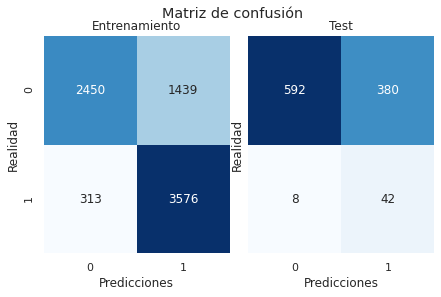

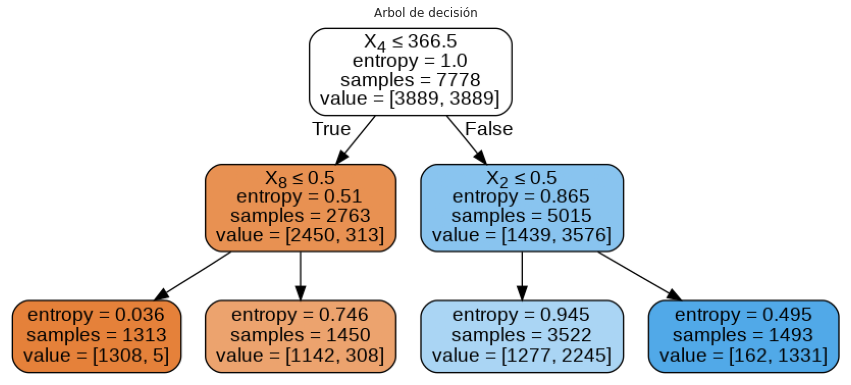

In [224]:
for hps in hiper_params:
    data = data_transform_pipeline(sets_group, hps)

    # Resumen de estrutura de los datos...
    data.summary()

    # Creamos el modelo (Arbol de decisión)...
    model = ModelFactory.create(hps)

    # Entrenamos...
    model.fit(data)
    summary = model.evaluate(data)
    
    # Mostramos el resumen de metricas...
    summary.show()

#### g.1) Armar conjuntos de entrenamiento y validación con proporción 80-20 del conjunto de desarrollo de forma aleatoria. Usar 50 semillas distintas y realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en c) en esas 50 particiones distintas.

In [225]:
class MetricsComparePlot:
    def __init__(self):
        self.accs = []
        self.precisions = []
        self.recalls = []
        self.f1s = []

    def add(self, y_val,y_pred_val):
        self.accs.append(accuracy_score(y_val,y_pred_val))
        self.precisions.append(precision_score(y_val,y_pred_val))
        self.recalls.append(recall_score(y_val,y_pred_val))
        self.f1s.append(f1_score(y_val,y_pred_val))

    def plot(self):
        all_metrics = self.accs + self.precisions + self.recalls + self.f1s
        metric_labels = ['Accuracy']*len(self.accs) + ['Precision']*len(self.precisions) + ['Recall']*len(self.recalls) + ['F1 Score']*len(self.f1s)
        sns.set_context('talk')
        plt.figure(figsize=(15,8))
        sns.boxplot(metric_labels, all_metrics)
        plt.show()

In [ ]:
# Rearmo dataset dev (feat+tgt) y vuelvo a correr train/test 
# split, ya que el primero separó dev + val
dev_concat = sets_group.dev_set()

n_seeds   = 50
test_size = 0.2
plotter   = MetricsComparePlot()

for seed in range(n_seeds):
    hps = HiperParams(random_state = seed)

    sets_group_dev = DevTestSpliter.split(
        dev_concat, 
        test_size = test_size, 
        random_state = hps.random_state
    )

    encoded_sets_group_dev = data_transform_pipeline(sets_group_dev, hps)

    arbol = ModelFactory.create(hps)
    arbol = arbol.fit(encoded_sets_group_dev)
    y_pred_val = arbol.predict(encoded_sets_group_dev.test_features)

    plotter.add(encoded_sets_group_dev.test_target, y_pred_val)

plotter.plot()

#### g.2) Usar validación cruzada de 50 iteraciones (50-fold cross validation). Realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en esas 50 particiones distintas.

In [ ]:
def search_best_model(sets_group, params_grid, n_splits, n_iter, metric_fc=f1_score):
    print('Random Search Hiper-params:', params_grid)
    randomcv = RandomizedSearchCV(
        estimator           = DecisionTreeClassifier(),
        param_distributions = params_grid,
        scoring             = make_scorer(metric_fc),
        cv                  = StratifiedKFold(n_splits=n_splits),
        n_iter              = n_iter,
        return_train_score  = True
    )
    randomcv.fit(
        sets_group.dev_features.values,
        sets_group.dev_target.values
    )
    
    random_cv_results = pd.DataFrame(randomcv.cv_results_)
    print('Models Count:', random_cv_results.shape[0])

    return randomcv

In [ ]:
def plot_randomcv_metrics(randomcv_result, metrics):
    df = pd.DataFrame(randomcv_result.cv_results_)
    normal_size()
    for metric in metrics:
        plt.plot(df[metric],  linestyle='-', marker='o', label=metric)
    plt.legend()
    plt.show()


def plot_randomcv_score(randomcv_result):
    plot_randomcv_metrics(randomcv_result, metrics=['mean_train_score','mean_test_score'])

In [ ]:
n_splits = 50

randomcv = search_best_model(
    encoded_sets_group_dev,
    params_grid = {
        'criterion': ['gini','entropy'],
        'max_depth': list(range(1, 50)),
        'min_samples_leaf': list(range(1, 50)),
        'class_weight': ['balanced']
    }, 
    n_splits = n_splits,
    n_iter = 50
)
plot_randomcv_score(randomcv)

In [ ]:
random_cv_results = pd.DataFrame(randomcv.cv_results_)
random_cv_results[random_cv_results.params == randomcv.best_params_]

In [ ]:
metric_labels = []
metric_labels = ['F1 Score']*n_splits

accs_kfold = []
for x in range(0,n_splits):
  col = 'split' + str(x) + '_test_score'
  accs_kfold.append(random_cv_results[col].values[0])

hue = []
hue = ['Arbol1']*n_splits
sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,accs_kfold,hue=hue)

#### h) Graficar el árbol de decisión con mejor performance encontrado en el punto g2). Analizar el árbol de decisión armado (atributos elegidos y decisiones evaluadas).

In [ ]:
def evaluate_model(estimator, sets_group):
    model = ModelFactory.create(estimator)
    model.fit(sets_group)
    summary = model.evaluate(sets_group)
    summary.show()

evaluate_model(
    estimator  = randomcv.best_estimator_,
    sets_group = encoded_sets_group_dev
)

#### i) Usando validación cruzada de 10 iteraciones (10-fold cross validation), probar distintos valores de α del algoritmo de poda mínima de complejidad de costos (algoritmo de poda de sklearn). Hacer gráficos de la performance en validación y entrenamiento en función del α. Explicar cómo varía la profundidad de los árboles al realizar la poda con distintos valores de α.

In [ ]:
def to_params_grid(hiper_params):
    params_grid = {}
    for name in hiper_params.keys():
        params_grid[name] = [hiper_params[name]]
    return params_grid

In [ ]:
params_grid = to_params_grid(randomcv.best_params_)
params_grid['ccp_alpha'] = np.linspace(0, 0.3, 100)

randomcv2 = search_best_model(
    encoded_sets_group_dev,
    params_grid = params_grid, 
    n_splits = 10,
    n_iter = 5
)

plot_randomcv_score(randomcv2)

#### j) Evaluar en el conjunto de evaluación, el árbol correspondiente al α que maximice la performance en el conjunto de validación. Comparar con el caso sin poda (α=0)

**Modelo con poda:**

In [ ]:
evaluate_model(
    estimator  = randomcv2.best_estimator_,
    sets_group = encoded_sets_group_dev
)

**Modelo sin poda**:

In [ ]:
evaluate_model(
    estimator  = randomcv.best_estimator_,
    sets_group = encoded_sets_group_dev
)

#### k) Para el árbol sin poda, obtener la importancia de los descriptores usando la técnica de eliminación recursiva. Reentrenar el árbol usando sólo los 3 descriptores más importantes. Comparar la performance en el conjunto de prueba.

**Completar!**